# AF2 predictions benchmark 

In [2]:
import json
import os
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt

results_dir = "/home/luisasantus/Desktop/crg_cluster/data/structural_regression/af2_structures/"

In [6]:
def get_plddt(results_dir, dataset):
    colabfold_dir = results_dir+"/colabfold_header/"
    plddt_summary = pd.DataFrame()
    for fam in os.listdir(colabfold_dir):
        fam_dir = os.path.join(colabfold_dir,fam)
        for f in os.listdir(os.path.join(fam_dir,"plddts")):
            if f.endswith('plddt.eval'):
                plddts = pd.read_csv(os.path.join(fam_dir,"plddts",f), sep = "\s+", header = None)
                plddts = plddts.set_axis(["sequence", "plddt"], axis=1)
                plddts["family"] = fam
                plddts["benchmarking_dataset"] = dataset
                
                plddt_summary = pd.concat([plddt_summary, plddts], ignore_index=True)
    return(plddt_summary)

In [7]:
# Extract plddt for each sequence in the family
af2_homfam = get_plddt(results_dir, "homfam")
af2_homfam.head(2)

,sequence,plddt,family,benchmarking_dataset
0,B2B1K0_PODAN_34-104,60.8602,ghf11,homfam
1,Q4P0L3_USTMA_34-219,86.6325,ghf11,homfam


In [8]:
# Summarize plddt family-wise
af2_homfam_summary = af2_homfam.groupby(['family',"benchmarking_dataset"]).agg({'plddt': ['mean', 'min', 'max']}).reset_index().set_axis(["family", "benchmarking_dataset", "plddt_mean", "plddt_min", "plddt_max"], axis=1)
af2_homfam_summary.head(2)

,family,benchmarking_dataset,plddt_mean,plddt_min,plddt_max
0,TNF,homfam,74.955996,44.3361,84.9513
1,ghf11,homfam,81.239152,49.6475,88.1020


In [9]:
summary_homfam_exthomfam = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/01_summary_homfam_exthomfam.csv")
summary_homfam_exthomfam = summary_homfam_exthomfam.rename(columns={"dataset": "benchmarking_dataset"})
summary_homfam_exthomfam.head(2)
stats_af2 = pd.merge(af2_homfam_summary, summary_homfam_exthomfam, on =["family","benchmarking_dataset"])

## Store files 

In [41]:
af2_homfam.to_csv(os.path.join("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/", "02_summary_af2.csv"), index = False)
af2_homfam_summary.to_csv(os.path.join("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/", "03_summary_af2_grouped.csv"), index = False)

# Visualize 

### How well does AF2 perform on the sequences in the families in the different datasets

In [53]:
af2_homfam_summary

,family,benchmarking_dataset,plddt_mean,plddt_min,plddt_max
0,TNF,homfam,74.955996,44.3361,84.9513
1,ghf11,homfam,81.239152,49.6475,88.1020
2,hip,homfam,78.387074,56.6983,82.6511
3,rnasemam,homfam,78.333078,57.8495,84.7626
4,scorptoxin,homfam,70.143942,52.2479,80.3438
5,seatoxin,homfam,63.094774,55.1243,71.2845
6,sti,homfam,77.721156,60.7132,85.1204
7,test,homfam,61.860650,55.3155,71.1619
8,toxin,homfam,74.358762,51.3286,79.7002


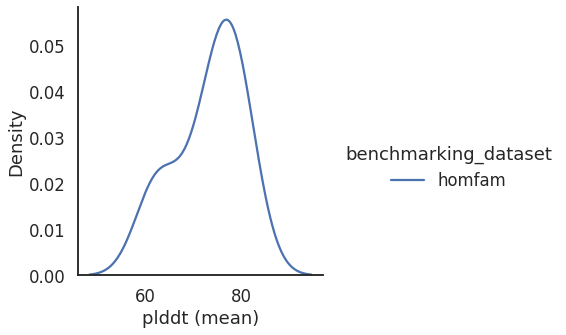

In [56]:
# Plot AF2 plddts summaries across families 
sns.set_theme(style="white")
sns.set_context("talk")
ax = sns.displot(af2_homfam_summary, x="plddt_mean", hue = "benchmarking_dataset", kind="kde")
ax.set(xlabel='plddt (mean)')

In [12]:
from Bio import SeqIO
seqs_dir="/home/luisasantus/Desktop/crg_cluster/data/structural_regression/"

def get_seq_lengths(seqs_dir, dataset, family):
    seqs_dir = os.path.join(*list([seqs_dir,dataset,"combinedSeqs"]))
    f = os.path.join(*list([seqs_dir,family+ ".fa"]))
    fasta_sequences = SeqIO.parse(open(f),'fasta')
    summary = pd.DataFrame()
    for fasta in fasta_sequences:
        name, sequence = fasta.id, str(fasta.seq)
        l = len(sequence)
        name = name.replace("/", "_")
        entry = pd.DataFrame([{"family": family,
                                "sequence": name,
                                "sequence length": l,
                                "benchmarking_dataset": dataset}])
        summary = pd.concat([summary,entry], ignore_index=True)
    return(summary)

In [13]:
# Get summary
summary_lengths = pd.DataFrame()
for family in stats_af2.family:
    summary_fam = get_seq_lengths(seqs_dir, "homfam", family)
    summary_lengths = pd.concat([summary_lengths,summary_fam], ignore_index=True)

In [47]:
af2_sequence_summary = pd.merge(af2_homfam, summary_lengths, on =["family","sequence","benchmarking_dataset"])

[Text(0, 0.5, 'sequence length')]

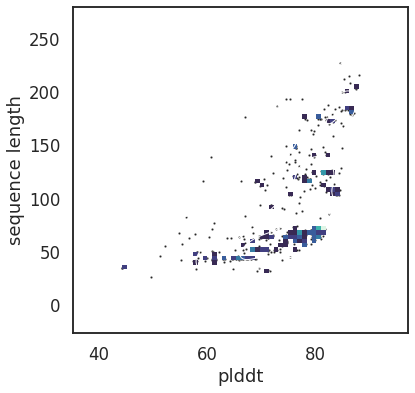

In [51]:
# Draw a combo histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(6, 6))
x=af2_sequence_summary.plddt
y=af2_sequence_summary["sequence length"]
sns.scatterplot(x=x, y=y, s=5, color=".15")
sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1)
ax.set(ylabel='sequence length')

['n: 399']


Text(1, 1, "['n: 399']")

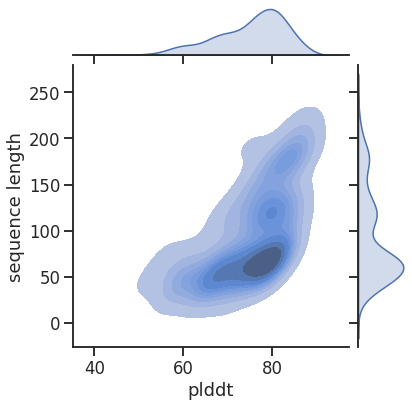

In [52]:
sns.set_theme(style="ticks")
sns.set_context("talk")


sns.jointplot(
    data=af2_sequence_summary,  fill=True, color = "red", legend = False, 
    x="plddt", y="sequence length", hue="benchmarking_dataset",
    kind="kde",
)

nobs = af2_sequence_summary['sequence'].value_counts().sum()
nobs = ["n: " + str(nobs)]
print(nobs)
# Add it to the plot
ax.text(1,1,nobs,horizontalalignment='center',size='small',color='red')


# Running times

In [138]:
structures_dir = "/home/luisasantus/Desktop/crg_cluster/data/structural_regression/af2_structures/colabfold"

In [153]:
# Parse in trace files 
traces = pd.DataFrame()
for fam in os.listdir(structures_dir):
        fam_dir = os.path.join(structures_dir,fam)
        for f in os.listdir(fam_dir):
            if f == ".command.trace":
                trace = join(fam_dir, f)
                df = pd.read_csv(trace, sep = "=").T
                df = df.rename(index={'nextflow.trace/v2': fam})
                traces = traces.append(df)


# Number of sequences with which it was run                
traces["nseq"] = 50
traces.reset_index(inplace=True)
traces = traces.rename(columns={'index': 'family'}) 

In [260]:
stats_homfam_seqs = summary_lengths_homfam.groupby(by=['family']).agg({'sequence length':['mean', 'median', "max"]})["sequence length"].reset_index()
# TODO Here to add also exthomfam
stats_seqs = stats_homfam_seqs
stats_seqs

,family,mean,median,max
0,Acetyltransf,82.989716,81.0,181
1,Ald_Xan_dh_2,109.303978,109.0,804
2,ChtBD,38.271318,40.0,54
3,DEATH,80.568893,82.0,150
4,DMRL_synthase,140.590281,144.0,168
...,...,...,...,...
90,tms,264.245042,274.0,488
91,toxin,62.311024,62.0,77
92,trfl,242.315412,305.0,689
93,uce,134.700527,138.0,193


In [252]:
traces_merged = pd.merge(traces, stats_homfam_seqs, on ="family")
traces_merged["hours"] = traces_merged.realtime/3600000
traces_merged.head(2)

,family,realtime,%cpu,rchar,wchar,syscr,syscw,read_bytes,write_bytes,%mem,...,rss,peak_vmem,peak_rss,vol_ctxt,inv_ctxt,nseq,mean,median,max,hours
0,ghf11,17610332,1127,7848555346,2610366791,17747499,24138051,3234155520,1308733440,17,...,13636024,92215400,13777948,7688898,6502209,50,167.758157,182.0,227,4.891759
1,rnasemam,10719559,1141,7084354660,1945084424,24928633,25618730,3113970688,887427072,13,...,10661388,89290304,10741992,7113185,9630057,50,120.072289,123.0,140,2.977655


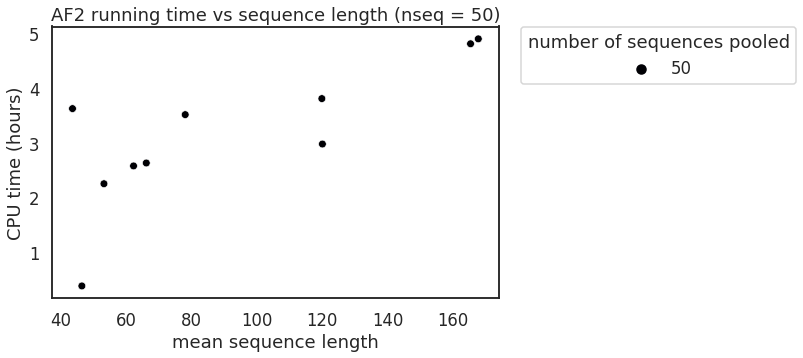

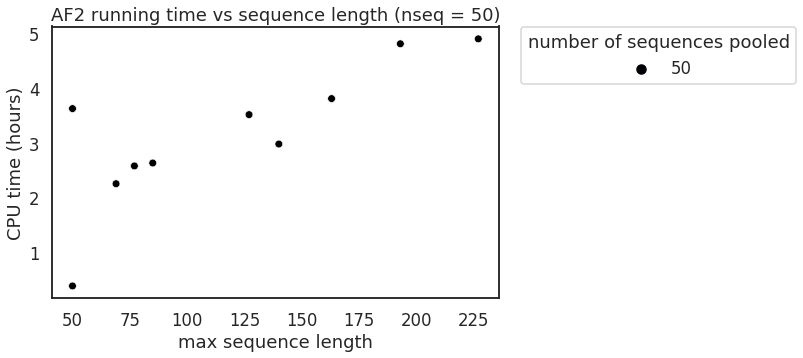

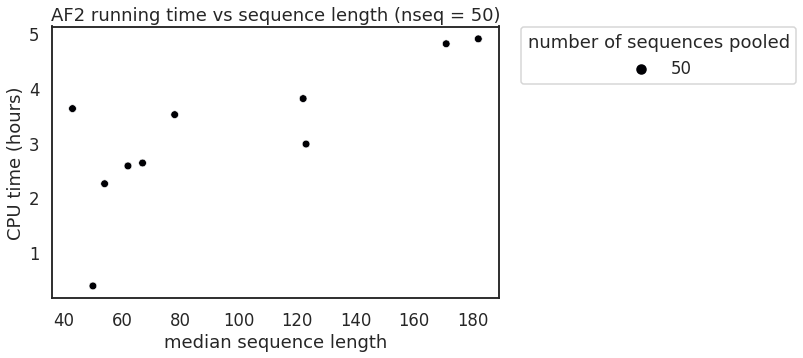

In [259]:
sns.set_context("talk")
metrics = ["mean","max", "median"]
for metric in metrics: 
    f, ax = plt.subplots(figsize=(8, 5))
    sns.scatterplot(data=traces_merged, y="hours", x=metric, hue="nseq",
                        palette = "magma", s = 60)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = "number of sequences pooled")
    ax.set(ylabel='CPU time (hours)', xlabel= metric +" sequence length", title = "AF2 running time vs sequence length (nseq = 50)")

In [265]:
summary_lengths["family"][1]

'Sulfotransfer'

In [264]:
np.unique(summary_lengths["family"])

array(['ChtBD', 'DEATH', 'Sulfotransfer', 'bowman', 'ghf10', 'ghf11',
       'glob', 'hormone_rec', 'hpr', 'hr', 'kringle', 'ldh', 'peroxidase',
       'ricin', 'rub', 'serpin', 'tgfb', 'tms'], dtype=object)